In [ ]:
# @title Imports

from typing import Any, Dict, Union, NamedTuple

import numpy as np
import tensorflow_datasets as tfds
import rlds
import reverb
from rlds import transformations
import tensorflow_datasets as tfds
import tree

import abc
import dataclasses
from typing import Dict, Optional

from rlds import rlds_types
import tensorflow as tf
from PIL import Image
from IPython import display
import tensorflow_datasets as tfds
import functools
from typing import Callable, Sequence
import matplotlib.pyplot as plt


In [ ]:
# @title Transformation definitions

# For an example behind the code in this code cell, please take a look at the
# dataset colab at the link below:
# https://colab.research.google.com/github/google-deepmind/open_x_embodiment/blob/main/colabs/Open_X_Embodiment_Datasets.ipynb

def _features_to_tensor_spec(
    feature: tfds.features.FeatureConnector
) -> tf.TensorSpec:
  """Converts a tfds Feature into a TensorSpec."""

  def _get_feature_spec(nested_feature: tfds.features.FeatureConnector):
    if isinstance(nested_feature, tf.DType):
      return tf.TensorSpec(shape=(), dtype=nested_feature)
    else:
      return nested_feature.get_tensor_spec()

  # FeaturesDict can sometimes be a plain dictionary, so we use tf.nest to
  # make sure we deal with the nested structure.
  return tf.nest.map_structure(_get_feature_spec, feature)


def _encoded_feature(feature: Optional[tfds.features.FeatureConnector],
                     image_encoding: Optional[str],
                     tensor_encoding: Optional[tfds.features.Encoding]):
  """Adds encoding to Images and/or Tensors."""
  def _apply_encoding(feature: tfds.features.FeatureConnector,
                      image_encoding: Optional[str],
                      tensor_encoding: Optional[tfds.features.Encoding]):
    if image_encoding and isinstance(feature, tfds.features.Image):
      return tfds.features.Image(
          shape=feature.shape,
          dtype=feature.dtype,
          use_colormap=feature.use_colormap,
          encoding_format=image_encoding)
    if tensor_encoding and isinstance(
        feature, tfds.features.Tensor) and feature.dtype != tf.string:
      return tfds.features.Tensor(
          shape=feature.shape, dtype=feature.dtype, encoding=tensor_encoding)
    return feature

  if not feature:
    return None
  return tf.nest.map_structure(
      lambda x: _apply_encoding(x, image_encoding, tensor_encoding), feature)


@dataclasses.dataclass
class RLDSSpec(metaclass=abc.ABCMeta):
  """Specification of an RLDS Dataset.

  It is used to hold a spec that can be converted into a TFDS DatasetInfo or
  a `tf.data.Dataset` spec.
  """
  observation_info: Optional[tfds.features.FeatureConnector] = None
  action_info: Optional[tfds.features.FeatureConnector] = None
  reward_info: Optional[tfds.features.FeatureConnector] = None
  discount_info: Optional[tfds.features.FeatureConnector] = None
  step_metadata_info: Optional[tfds.features.FeaturesDict] = None
  episode_metadata_info: Optional[tfds.features.FeaturesDict] = None

  def step_tensor_spec(self) -> Dict[str, tf.TensorSpec]:
    """Obtains the TensorSpec of an RLDS step."""
    step = {}
    if self.observation_info:
      step[rlds_types.OBSERVATION] = _features_to_tensor_spec(
          self.observation_info)
    if self.action_info:
      step[rlds_types.ACTION] = _features_to_tensor_spec(
          self.action_info)
    if self.discount_info:
      step[rlds_types.DISCOUNT] = _features_to_tensor_spec(
          self.discount_info)
    if self.reward_info:
      step[rlds_types.REWARD] = _features_to_tensor_spec(
          self.reward_info)
    if self.step_metadata_info:
      for k, v in self.step_metadata_info.items():
        step[k] = _features_to_tensor_spec(v)

    step[rlds_types.IS_FIRST] = tf.TensorSpec(shape=(), dtype=bool)
    step[rlds_types.IS_LAST] = tf.TensorSpec(shape=(), dtype=bool)
    step[rlds_types.IS_TERMINAL] = tf.TensorSpec(shape=(), dtype=bool)
    return step

  def episode_tensor_spec(self) -> Dict[str, tf.TensorSpec]:
    """Obtains the TensorSpec of an RLDS step."""
    episode = {}
    episode[rlds_types.STEPS] = tf.data.DatasetSpec(
        element_spec=self.step_tensor_spec())
    if self.episode_metadata_info:
      for k, v in self.episode_metadata_info.items():
        episode[k] = _features_to_tensor_spec(v)
    return episode

  def to_dataset_config(
      self,
      name: str,
      image_encoding: Optional[str] = None,
      tensor_encoding: Optional[tfds.features.Encoding] = None,
      citation: Optional[str] = None,
      homepage: Optional[str] = None,
      description: Optional[str] = None,
      overall_description: Optional[str] = None,
  ) -> tfds.rlds.rlds_base.DatasetConfig:
    """Obtains the DatasetConfig for TFDS from the Spec."""
    return tfds.rlds.rlds_base.DatasetConfig(
        name=name,
        description=description,
        overall_description=overall_description,
        homepage=homepage,
        citation=citation,
        observation_info=_encoded_feature(self.observation_info, image_encoding,
                                          tensor_encoding),
        action_info=_encoded_feature(self.action_info, image_encoding,
                                     tensor_encoding),
        reward_info=_encoded_feature(self.reward_info, image_encoding,
                                     tensor_encoding),
        discount_info=_encoded_feature(self.discount_info, image_encoding,
                                       tensor_encoding),
        step_metadata_info=_encoded_feature(self.step_metadata_info,
                                            image_encoding, tensor_encoding),
        episode_metadata_info=_encoded_feature(self.episode_metadata_info,
                                               image_encoding, tensor_encoding))

  def to_features_dict(self):
    """Returns a TFDS FeaturesDict representing the dataset config."""
    step_config = {
        rlds_types.IS_FIRST: tf.bool,
        rlds_types.IS_LAST: tf.bool,
        rlds_types.IS_TERMINAL: tf.bool,
    }

    if self.observation_info:
      step_config[rlds_types.OBSERVATION] = self.observation_info
    if self.action_info:
      step_config[rlds_types.ACTION] = self.action_info
    if self.discount_info:
      step_config[rlds_types.DISCOUNT] = self.discount_info
    if self.reward_info:
      step_config[rlds_types.REWARD] = self.reward_info

    if self.step_metadata_info:
      for k, v in self.step_metadata_info.items():
        step_config[k] = v

    if self.episode_metadata_info:
      return tfds.features.FeaturesDict({
          rlds_types.STEPS: tfds.features.Dataset(step_config),
          **self.episode_metadata_info,
      })
    else:
      return tfds.features.FeaturesDict({
          rlds_types.STEPS: tfds.features.Dataset(step_config),
      })

RLDS_SPEC = RLDSSpec
TENSOR_SPEC = Union[tf.TensorSpec, dict[str, tf.TensorSpec]]


@dataclasses.dataclass
class TrajectoryTransform(metaclass=abc.ABCMeta):
  """Specification the TrajectoryTransform applied to a dataset of episodes.

  A TrajectoryTransform is a set of rules transforming a dataset
  of RLDS episodes to a dataset of trajectories.
  This involves three distinct stages:
  - An optional `episode_to_steps_map_fn(episode)` is called at the episode
    level, and can be used to select or modify steps.
    - Augmentation: an `episode_key` could be propagated to `steps` for
      debugging.
    - Selection: Particular steps can be selected.
    - Stripping: Features can be removed from steps. Prefer using `step_map_fn`.
  - An optional `step_map_fn` is called at the flattened steps dataset for each
    step, and can be used to featurize a step, e.g. add/remove features, or
    augument images
  - A `pattern` leverages DM patterns to set a rule of slicing an episode to a
    dataset of overlapping trajectories.

  Importantly, each TrajectoryTransform must define a `expected_tensor_spec`
  which specifies a nested TensorSpec of the resulting dataset. This is what
  this TrajectoryTransform will produce, and can be used as an interface with
  a neural network.
  """
  episode_dataset_spec: RLDS_SPEC
  episode_to_steps_fn_dataset_spec: RLDS_SPEC
  steps_dataset_spec: Any
  pattern: reverb.structured_writer.Pattern
  episode_to_steps_map_fn: Any
  expected_tensor_spec: TENSOR_SPEC
  step_map_fn: Optional[Any] = None

  def get_for_cached_trajectory_transform(self):
    """Creates a copy of this traj transform to use with caching.

    The returned TrajectoryTransfrom copy will be initialized with the default
    version of the `episode_to_steps_map_fn`, because the effect of that
    function has already been materialized in the cached copy of the dataset.
    Returns:
      trajectory_transform: A copy of the TrajectoryTransform with overridden
        `episode_to_steps_map_fn`.
    """
    traj_copy = dataclasses.replace(self)
    traj_copy.episode_dataset_spec = traj_copy.episode_to_steps_fn_dataset_spec
    traj_copy.episode_to_steps_map_fn = lambda e: e[rlds_types.STEPS]
    return traj_copy

  def transform_episodic_rlds_dataset(self, episodes_dataset: tf.data.Dataset):
    """Applies this TrajectoryTransform to the dataset of episodes."""

    # Convert the dataset of episodes to the dataset of steps.
    steps_dataset = episodes_dataset.map(
        self.episode_to_steps_map_fn, num_parallel_calls=tf.data.AUTOTUNE
    ).flat_map(lambda x: x)

    return self._create_pattern_dataset(steps_dataset)

  def transform_steps_rlds_dataset(
      self, steps_dataset: tf.data.Dataset
  ) -> tf.data.Dataset:
    """Applies this TrajectoryTransform to the dataset of episode steps."""

    return self._create_pattern_dataset(steps_dataset)

  def create_test_dataset(
      self,
  ) -> tf.data.Dataset:
    """Creates a test dataset of trajectories.

    It is guaranteed that the structure of this dataset will be the same as
    when flowing real data. Hence this is a useful construct for tests or
    initialization of JAX models.
    Returns:
      dataset: A test dataset made of zeros structurally identical to the
        target dataset of trajectories.
    """
    zeros = transformations.zeros_from_spec(self.expected_tensor_spec)

    return tf.data.Dataset.from_tensors(zeros)

  def _create_pattern_dataset(
      self, steps_dataset: tf.data.Dataset) -> tf.data.Dataset:
    """Create PatternDataset from the `steps_dataset`."""
    config = create_structured_writer_config('temp', self.pattern)

    # Further transform each step if the `step_map_fn` is provided.
    if self.step_map_fn:
      steps_dataset = steps_dataset.map(self.step_map_fn)
    pattern_dataset = reverb.PatternDataset(
        input_dataset=steps_dataset,
        configs=[config],
        respect_episode_boundaries=True,
        is_end_of_episode=lambda x: x[rlds_types.IS_LAST])
    return pattern_dataset


class TrajectoryTransformBuilder(object):
  """Facilitates creation of the `TrajectoryTransform`."""

  def __init__(self,
               dataset_spec: RLDS_SPEC,
               episode_to_steps_map_fn=lambda e: e[rlds_types.STEPS],
               step_map_fn=None,
               pattern_fn=None,
               expected_tensor_spec=None):
    self._rds_dataset_spec = dataset_spec
    self._steps_spec = None
    self._episode_to_steps_map_fn = episode_to_steps_map_fn
    self._step_map_fn = step_map_fn
    self._pattern_fn = pattern_fn
    self._expected_tensor_spec = expected_tensor_spec

  def build(self,
            validate_expected_tensor_spec: bool = True) -> TrajectoryTransform:
    """Creates `TrajectoryTransform` from a `TrajectoryTransformBuilder`."""

    if validate_expected_tensor_spec and self._expected_tensor_spec is None:
      raise ValueError('`expected_tensor_spec` must be set.')

    episode_ds = zero_episode_dataset_from_spec(self._rds_dataset_spec)

    steps_ds = episode_ds.flat_map(self._episode_to_steps_map_fn)

    episode_to_steps_fn_dataset_spec = self._rds_dataset_spec

    if self._step_map_fn is not None:
      steps_ds = steps_ds.map(self._step_map_fn)

    zeros_spec = transformations.zeros_from_spec(steps_ds.element_spec)  # pytype: disable=wrong-arg-types

    ref_step = reverb.structured_writer.create_reference_step(zeros_spec)

    pattern = self._pattern_fn(ref_step)

    steps_ds_spec = steps_ds.element_spec

    target_tensor_structure = create_reverb_table_signature(
        'temp_table', steps_ds_spec, pattern)

    if (validate_expected_tensor_spec and
        self._expected_tensor_spec != target_tensor_structure):
      raise RuntimeError(
          'The tensor spec of the TrajectoryTransform doesn\'t '
          'match the expected spec.\n'
          'Expected:\n%s\nActual:\n%s\n' %
          (str(self._expected_tensor_spec).replace('TensorSpec',
                                                   'tf.TensorSpec'),
           str(target_tensor_structure).replace('TensorSpec', 'tf.TensorSpec')))

    return TrajectoryTransform(
        episode_dataset_spec=self._rds_dataset_spec,
        episode_to_steps_fn_dataset_spec=episode_to_steps_fn_dataset_spec,
        steps_dataset_spec=steps_ds_spec,
        pattern=pattern,
        episode_to_steps_map_fn=self._episode_to_steps_map_fn,
        step_map_fn=self._step_map_fn,
        expected_tensor_spec=target_tensor_structure)

def zero_episode_dataset_from_spec(rlds_spec: RLDS_SPEC):
  """Creates a zero valued dataset of episodes for the given RLDS Spec."""

  def add_steps(episode, step_spec):
    episode[rlds_types.STEPS] = transformations.zero_dataset_like(
        tf.data.DatasetSpec(step_spec))
    if 'fake' in episode:
      del episode['fake']
    return episode

  episode_without_steps_spec = {
      k: v
      for k, v in rlds_spec.episode_tensor_spec().items()
      if k != rlds_types.STEPS
  }

  if episode_without_steps_spec:
    episodes_dataset = transformations.zero_dataset_like(
        tf.data.DatasetSpec(episode_without_steps_spec))
  else:
    episodes_dataset = tf.data.Dataset.from_tensors({'fake': ''})

  episodes_dataset_with_steps = episodes_dataset.map(
      lambda episode: add_steps(episode, rlds_spec.step_tensor_spec()))
  return episodes_dataset_with_steps


def create_reverb_table_signature(table_name: str, steps_dataset_spec,
                                  pattern: reverb.structured_writer.Pattern) -> reverb.reverb_types.SpecNest:
  config = create_structured_writer_config(table_name, pattern)
  reverb_table_spec = reverb.structured_writer.infer_signature(
      [config], steps_dataset_spec)
  return reverb_table_spec


def create_structured_writer_config(table_name: str,
                                    pattern: reverb.structured_writer.Pattern) -> Any:
  config = reverb.structured_writer.create_config(
      pattern=pattern, table=table_name, conditions=[])
  return config

def n_step_pattern_builder(n: int) -> Any:
  """Creates trajectory of length `n` from all fields of a `ref_step`."""

  def transform_fn(ref_step):
    traj = {}
    for key in ref_step:
      if isinstance(ref_step[key], dict):
        transformed_entry = tree.map_structure(lambda ref_node: ref_node[-n:],
                                               ref_step[key])
        traj[key] = transformed_entry
      else:
        traj[key] = ref_step[key][-n:]

    return traj

  return transform_fn

In [ ]:
# @title Shared map functions

StepFnMapType = Callable[[rlds.Step, rlds.Step], None]


def resize_to_resolution(
    image: Union[tf.Tensor, np.ndarray],
    target_width: int = 320,
    target_height: int = 256,
    to_numpy: bool = True,
) -> Union[tf.Tensor, np.ndarray]:
  """Resizes image and casts to uint8."""
  image = tf.image.resize_with_pad(
      image,
      target_width=target_width,
      target_height=target_height,
  )
  image = tf.cast(image, tf.uint8)
  if to_numpy:
    image = image.numpy()
  return image


def map_observation(
    to_step: rlds.Step,
    from_step: rlds.Step,
    from_image_feature_names: tuple[str, ...] = ('image',),
    to_image_feature_names: tuple[str, ...] = ('image',),
    resize: bool = True,
) -> None:
  """Map observation to model observation spec."""

  to_step[rlds.OBSERVATION]['natural_language_embedding'] = from_step[
      rlds.OBSERVATION
  ]['natural_language_embedding']

  for from_feature_name, to_feature_name in zip(
      from_image_feature_names, to_image_feature_names
  ):
    if resize:
      to_step['observation'][to_feature_name] = resize_to_resolution(
          from_step['observation'][from_feature_name],
          to_numpy=False,
          target_width=320,
          target_height=256,
      )


def terminate_bool_to_act(terminate_episode: tf.Tensor) -> tf.Tensor:
  return tf.cond(
      terminate_episode == tf.constant(1.0),
      lambda: tf.constant([1, 0, 0], dtype=tf.int32),
      lambda: tf.constant([0, 1, 0], dtype=tf.int32),
  )

In [ ]:
# @title RT-1 action map function


def rt_1_map_action(to_step: rlds.Step, from_step: rlds.Step):
  to_step[rlds.ACTION] = from_step[rlds.ACTION]

  del to_step[rlds.ACTION]['base_displacement_vector']
  del to_step[rlds.ACTION]['base_displacement_vertical_rotation']


In [ ]:
# @title Bridge action map function

def rescale_action_with_bound(
    actions: tf.Tensor,
    low: float,
    high: float,
    safety_margin: float = 0,
    post_scaling_max: float = 1.0,
    post_scaling_min: float = -1.0,
) -> tf.Tensor:
  """Formula taken from https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range."""
  resc_actions = (actions - low) / (high - low) * (
      post_scaling_max - post_scaling_min
  ) + post_scaling_min
  return tf.clip_by_value(
      resc_actions,
      post_scaling_min + safety_margin,
      post_scaling_max - safety_margin,
  )


def _rescale_action(action):
  """Rescales action."""

  # Values taken from
  # https://github.com/Asap7772/rt1_eval/blob/2fad77e9bf4def2ef82604d445270f83475e9726/kitchen_eval/rt1_wrapper.py#L39
  action['world_vector'] = rescale_action_with_bound(
      action['world_vector'],
      low=-0.05,
      high=0.05,
      safety_margin=0.01,
      post_scaling_max=1.75,
      post_scaling_min=-1.75,
  )
  action['rotation_delta'] = rescale_action_with_bound(
      action['rotation_delta'],
      low=-0.25,
      high=0.25,
      safety_margin=0.01,
      post_scaling_max=1.4,
      post_scaling_min=-1.4,
  )

  return action


def bridge_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps Bridge dataset action to action expected by the model."""

  to_step['action']['world_vector'] = from_step['action']['world_vector']
  to_step['action']['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )

  to_step['action']['rotation_delta'] = from_step['action']['rotation_delta']

  open_gripper = from_step['action']['open_gripper']

  possible_values = tf.constant([True, False], dtype=tf.bool)
  eq = tf.equal(possible_values, open_gripper)

  assert_op = tf.Assert(tf.reduce_any(eq), [open_gripper])

  with tf.control_dependencies([assert_op]):
    to_step['action']['gripper_closedness_action'] = tf.cond(
        # for open_gripper in bridge dataset,
        # 0 is fully closed and 1 is fully open
        open_gripper,
        # for Fractal data,
        # gripper_closedness_action = -1 means opening the gripper and
        # gripper_closedness_action = 1 means closing the gripper.
        lambda: tf.constant([-1.0], dtype=tf.float32),
        lambda: tf.constant([1.0], dtype=tf.float32),
    )

  to_step['action'] = _rescale_action(to_step['action'])


In [ ]:
# @title Task Agnostic Robot Play map function

def taco_play_rescale_actions_by_bounds(actions, lows, highs, safety_margin=0.01):
  # Actions is SymbolicTensor, shape (N,)
  resc_actions = (actions - lows) / (highs - lows) * 2 - 1
  return tf.clip_by_value(resc_actions, -1 + safety_margin, 1 - safety_margin)



def taco_play_rescale_action(action):
  """Rescales actions based on measured per dimension ranges."""
  # Rotation Delta
  rd_lows = tf.constant([-3.2, -0.8, -1.8])
  rd_highs = tf.constant([3.2, 0.2, 2.5])
  action['rotation_delta'] = taco_play_rescale_actions_by_bounds(
      action['rotation_delta'], lows=rd_lows, highs=rd_highs
  )

  # World Vector
  wv_lows = tf.constant([0.0, -0.5, 0.0])
  wv_highs = tf.constant([0.8, 0.7, 0.6])
  action['world_vector'] = taco_play_rescale_actions_by_bounds(
      action['world_vector'], lows=wv_lows, highs=wv_highs
  )

  return action


def taco_play_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps Taco Play Panda action to action expected by the model."""

  # 'actions' is absolute, and not relative action. There is relative action in
  # the materialized dataset that can be used for training (not yet supported).
  actions = from_step[rlds.ACTION]['actions']
  to_step[rlds.ACTION]['world_vector'] = actions[:3]
  to_step[rlds.ACTION]['terminate_episode'] = terminate_bool_to_act(
      from_step[rlds.ACTION]['terminate_episode']
  )

  to_step[rlds.ACTION]['rotation_delta'] = actions[3:6]
  to_step[rlds.ACTION]['gripper_closedness_action'] = tf.expand_dims(
      actions[6], axis=-1
  )

  to_step[rlds.ACTION] = _rescale_action(to_step[rlds.ACTION])


taco_play_map_observation = functools.partial(
    map_observation,
    from_image_feature_names=('rgb_static',),
    to_image_feature_names=('image',))


In [ ]:
# @title Jaco Play map function

def _normalize(value, mean, std):
  return (value - mean) / std


def jaco_play_map_action(to_step: rlds.Step, from_step: rlds.Step):
  to_step['action']['world_vector'] = _normalize(
      from_step['action']['world_vector'],
      mean=tf.constant(
          [0.00096585, -0.00580069, -0.00395066], dtype=tf.float32
      ),
      std=tf.constant([0.12234575, 0.09676983, 0.11155209], dtype=tf.float32),
  )
  to_step['action']['gripper_closedness_action'] = from_step['action'][
      'gripper_closedness_action'
  ]
  to_step['action']['terminate_episode'] = from_step['action'][
      'terminate_episode'
  ]


In [ ]:
# @title Cable Routing map function

def berkeley_cable_routing_map_action(to_step: rlds.Step, from_step: rlds.Step):

  to_step['action']['world_vector'] = from_step['action']['world_vector']
  to_step['action']['rotation_delta'] = from_step['action']['rotation_delta']

  to_step['action']['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )


In [ ]:
# @title RoboTurk map function

def roboturk_map_action(to_step: rlds.Step, from_step: rlds.Step):
  to_step[rlds.ACTION]['world_vector'] = from_step[rlds.ACTION]['world_vector']
  to_step[rlds.ACTION]['gripper_closedness_action'] = from_step[rlds.ACTION][
      'gripper_closedness_action'
  ]
  to_step[rlds.ACTION]['rotation_delta'] = from_step[rlds.ACTION]['rotation_delta']
  to_step[rlds.ACTION]['terminate_episode'] = terminate_bool_to_act(
      from_step[rlds.ACTION]['terminate_episode']
  )

roboturk_map_observation = functools.partial(
    map_observation,
    from_image_feature_names=('front_rgb',),
    to_image_feature_names=('image',)
)

In [ ]:
# @title NYU VINN map function

def nyu_door_opening_surprising_effectiveness_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps dataset action to action expected by the model."""

  # The world vector as existed in the dataset on disk ranges from -0.07 to 0.07
  # We scale by 20.0 so that the action spans the limit of the world_vector
  # action, from -2.0 to 2.0.
  to_step['action']['world_vector'] = from_step['action']['world_vector'] * 20.0

  # Similarly, the rotation_delta in the dataset on disk ranges from -0.07 to
  # 0.07.
  # We scale by 15.0 so that the rotation_delta almost spans the limit of
  # rotation_delta, from -pi/2 to pi/2.
  to_step['action']['rotation_delta'] = (
      from_step['action']['rotation_delta'] * 15.0
  )

  to_step['action']['gripper_closedness_action'] = (
      from_step['action']['gripper_closedness_action']
  )

  to_step['action']['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )


In [ ]:
# @title Austin VIOLA map function

def viola_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps dataset action to action expected by the model."""

  # The world vector as existed in the dataset on disk ranges from -1.0 to 1.0
  # We scale by 1.75 so that the action better spans the limit of the
  # world_vector action, from -2.0 to 2.0.
  to_step[rlds.ACTION]['world_vector'] = from_step[rlds.ACTION]['world_vector'] * 1.75
  to_step[rlds.ACTION]['terminate_episode'] = terminate_bool_to_act(
      from_step[rlds.ACTION]['terminate_episode']
  )

  # Similarly, the rotation_delta in the dataset on disk ranges from -0.4 to 0.4
  # We scale by 3.0 so that the rotation_delta almost spans the limit of
  # rotation_delta, from -pi/2 to pi/2.
  to_step[rlds.ACTION]['rotation_delta'] = (
      from_step[rlds.ACTION]['rotation_delta'] * 3.0
  )

  gripper_closedness_action = from_step[rlds.ACTION]['gripper_closedness_action']

  # There can be 0.0 values because of zero padding
  possible_values = tf.constant([-1.0, 1.0, 0.0], dtype=tf.float32)
  eq = tf.equal(possible_values, gripper_closedness_action)

  # Assert that gripper_closedness_action is one of possible_values
  assert_op = tf.Assert(tf.reduce_any(eq), [gripper_closedness_action])

  with tf.control_dependencies([assert_op]):
    gripper_closedness_action = tf.expand_dims(
        gripper_closedness_action, axis=-1
    )
    to_step[rlds.ACTION]['gripper_closedness_action'] = gripper_closedness_action


viola_map_observation = functools.partial(
    map_observation,
    from_image_feature_names = ('agentview_rgb',),
    to_image_feature_names = ('image',),
)

In [ ]:
# @title Berkeley Autolab UR5 map function

def berkeley_autolab_ur5_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps Berkeley Autolab UR5 action to action expected by the model."""

  # The world vector as existed in the dataset on disk ranges from -0.02 to 0.02
  # We scale by 100.0 so that the action spans the limit of the world_vector
  # action, from -2.0 to 2.0.
  to_step[rlds.ACTION]['world_vector'] = (
      from_step[rlds.ACTION]['world_vector'] * 100.0
  )
  to_step[rlds.ACTION]['terminate_episode'] = terminate_bool_to_act(
      from_step[rlds.ACTION]['terminate_episode']
  )

  # Similarly, the rotation_delta in the dataset on disk ranges from -0.07 to
  # 0.07
  # We scale by 15.0 so that the rotation_delta almost spans the limit of
  # rotation_delta, from -pi/2 to pi/2.
  to_step[rlds.ACTION]['rotation_delta'] = (
      from_step[rlds.ACTION]['rotation_delta'] * 15.0
  )
  to_step[rlds.ACTION]['gripper_closedness_action'] = tf.expand_dims(
      from_step[rlds.ACTION]['gripper_closedness_action'], axis=0
  )


In [ ]:
# @title TOTO

def toto_map_action(to_step: rlds.Step, from_step: rlds.Step):
  """Maps TOTO action to action expected by the model."""

  # The world vector as existed in the dataset on disk ranges from -0.7 to 0.7
  # We scale by 2.0 so that the action better spans the limit of the
  # world_vector action, from -2.0 to 2.0.
  to_step['action']['world_vector'] = from_step['action']['world_vector'] * 2.0
  to_step['action']['terminate_episode'] = terminate_bool_to_act(
      from_step['action']['terminate_episode']
  )

  to_step['action']['rotation_delta'] = from_step['action']['rotation_delta']
  to_step['action']['gripper_closedness_action'] = tf.expand_dims(
      from_step['action']['open_gripper'], axis=0
  )
  to_step['action']['gripper_closedness_action'] = tf.cast(
      to_step['action']['gripper_closedness_action'], tf.float32
  )


In [ ]:
# @title Create trajectory datasets

def pad_initial_zero_steps(
    steps: tf.data.Dataset, num_zero_step: int
) -> tf.data.Dataset:
  zero_steps = steps.take(1)
  zero_steps = zero_steps.map(lambda x: tf.nest.map_structure(tf.zeros_like, x),
                              num_parallel_calls=tf.data.AUTOTUNE)
  zero_steps = zero_steps.repeat(num_zero_step)
  return rlds.transformations.concatenate(zero_steps, steps)


def pad_initial_zero_episode(episode: tf.data.Dataset, num_zero_step: int) -> tf.data.Dataset:
  episode[rlds.STEPS] = pad_initial_zero_steps(episode[rlds.STEPS], num_zero_step)
  return episode


def get_trajectory_dataset(builder_dir: str, step_map_fn, trajectory_length: int, split='train[:10]'):
  dataset_builder = tfds.builder_from_directory(builder_dir=builder_dir)

  dataset_builder_episodic_dataset = dataset_builder.as_dataset(split=split)

  # We need pad_initial_zero_episode because reverb.PatternDataset will skip
  # constructing trajectories where the first trajectory_length - 1 steps are
  # the final step in a trajectory. As such, without padding, the policies will
  # not be trained to predict the actions in the first trajectory_length - 1
  # steps.
  # We are padding with num_zero_step=trajectory_length-1 steps.
  dataset_builder_episodic_dataset = dataset_builder_episodic_dataset.map(
      functools.partial(pad_initial_zero_episode, num_zero_step=trajectory_length-1), num_parallel_calls=tf.data.AUTOTUNE)

  rlds_spec = RLDSSpec(
      observation_info=dataset_builder.info.features[rlds.STEPS][rlds.OBSERVATION],
      action_info=dataset_builder.info.features[rlds.STEPS][rlds.ACTION],
  )

  trajectory_transform = TrajectoryTransformBuilder(rlds_spec,
                                                    step_map_fn=step_map_fn,
                                                    pattern_fn=n_step_pattern_builder(trajectory_length)).build(validate_expected_tensor_spec=False)

  trajectory_dataset = trajectory_transform.transform_episodic_rlds_dataset(dataset_builder_episodic_dataset)

  return trajectory_dataset


def step_map_fn(step, map_observation: StepFnMapType, map_action: StepFnMapType):
  transformed_step = {}
  transformed_step[rlds.IS_FIRST] = step[rlds.IS_FIRST]
  transformed_step[rlds.IS_LAST] = step[rlds.IS_LAST]
  transformed_step[rlds.IS_TERMINAL] = step[rlds.IS_TERMINAL]

  transformed_step[rlds.OBSERVATION] = {}
  transformed_step[rlds.ACTION] = {
    'gripper_closedness_action': tf.zeros(1, dtype=tf.float32),
    'rotation_delta': tf.zeros(3, dtype=tf.float32),
    'terminate_episode': tf.zeros(3, dtype=tf.int32),
    'world_vector': tf.zeros(3, dtype=tf.float32)
  }

  map_observation(transformed_step, step)
  map_action(transformed_step, step)

  return transformed_step


DATASET_NAME_TO_TRAJECTORY_DATASET_KWARGS = {
    # RT-1
    'rt_1': {
        'builder_dir': 'gs://gresearch/robotics/fractal20220817_data/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=rt_1_map_action)
    },
    # TODO: (add Qt-Opt)
    # Bridge
    'bridge': {
        'builder_dir': 'gs://gresearch/robotics/bridge/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=bridge_map_action)
    },
    #  Task Agnostic Robot Play
    'taco_play': {
        'builder_dir': 'gs://gresearch/robotics/taco_play/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=taco_play_map_observation,
                                        map_action=taco_play_map_action)
    },
    # Jaco Play
    'jaco_play': {
        'builder_dir': 'gs://gresearch/robotics/jaco_play/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=jaco_play_map_action)
    },
    # Cable Routing
    'berkeley_cable_routing': {
        'builder_dir': 'gs://gresearch/robotics/berkeley_cable_routing/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=berkeley_cable_routing_map_action)
    },
    # Roboturk
    'roboturk': {
        'builder_dir': 'gs://gresearch/robotics/roboturk/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=roboturk_map_observation,
                                        map_action=roboturk_map_action)
    },
    # NYU VINN
    'nyu_door_opening_surprising_effectiveness': {
        'builder_dir': 'gs://gresearch/robotics/nyu_door_opening_surprising_effectiveness/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=nyu_door_opening_surprising_effectiveness_map_action)
    },
    # Austin VIOLA
    'viola': {
        'builder_dir': 'gs://gresearch/robotics/viola/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=viola_map_observation,
                                        map_action=viola_map_action)
    },
    # Berkeley Autolab UR5
    'berkeley_autolab_ur5': {
        'builder_dir': 'gs://gresearch/robotics/berkeley_autolab_ur5/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=berkeley_autolab_ur5_map_action)
    },
    # TODO: (add Language Table)
    'toto': {
        'builder_dir': 'gs://gresearch/robotics/toto/0.1.0',
        'trajectory_length': 15,
        'step_map_fn':functools.partial(step_map_fn,
                                        map_observation=map_observation,
                                        map_action=toto_map_action)
    }
}


DATASET_NAME_TO_TRAJECTORY_DATASET = {k: get_trajectory_dataset(**v) for k, v in DATASET_NAME_TO_TRAJECTORY_DATASET_KWARGS.items()}

In [ ]:
# @title Dataset weights

DATASET_NAME_TO_WEIGHTS = {
    'rt_1': 150,
    # 'rlds.kuka': 20,
    'bridge': 50,
    'taco_play': 5,
    'jaco_play': 20,
    'berkeley_cable_routing': 20,
    'roboturk': 10,
    'nyu_door_opening_surprising_effectiveness': 5,
    'viola': 3,
    'berkeley_autolab_ur5': 5,
    # 'language_table.language_table': 30,
    'toto': 5,
}

In [ ]:
# @title Batch, and sample one training sample

# Larger shuffle buffer leads to better performance, but consumes more RAM
datasets = []
weights = []

for name, dataset in DATASET_NAME_TO_TRAJECTORY_DATASET.items():

  datasets.append(dataset.shuffle(10))
  weights.append(float(DATASET_NAME_TO_WEIGHTS[name]))

dataset = tf.data.Dataset.sample_from_datasets(datasets, weights=weights)

# Larger shuffle buffer leads to better performance, but consumes more RAM
dataset = dataset.shuffle(1)

dataset = dataset.batch(6)

trajectory_dataset_iter = iter(dataset)

sample = next(trajectory_dataset_iter)

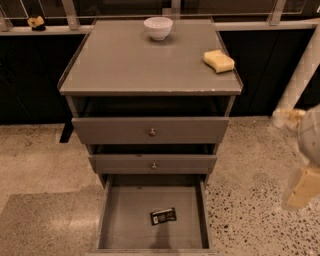

In [ ]:
Image.fromarray(sample[rlds.OBSERVATION]['image'].numpy()[0][-1])

In [ ]:
sample[rlds.OBSERVATION]['image'].shape

TensorShape([6, 15, 256, 320, 3])

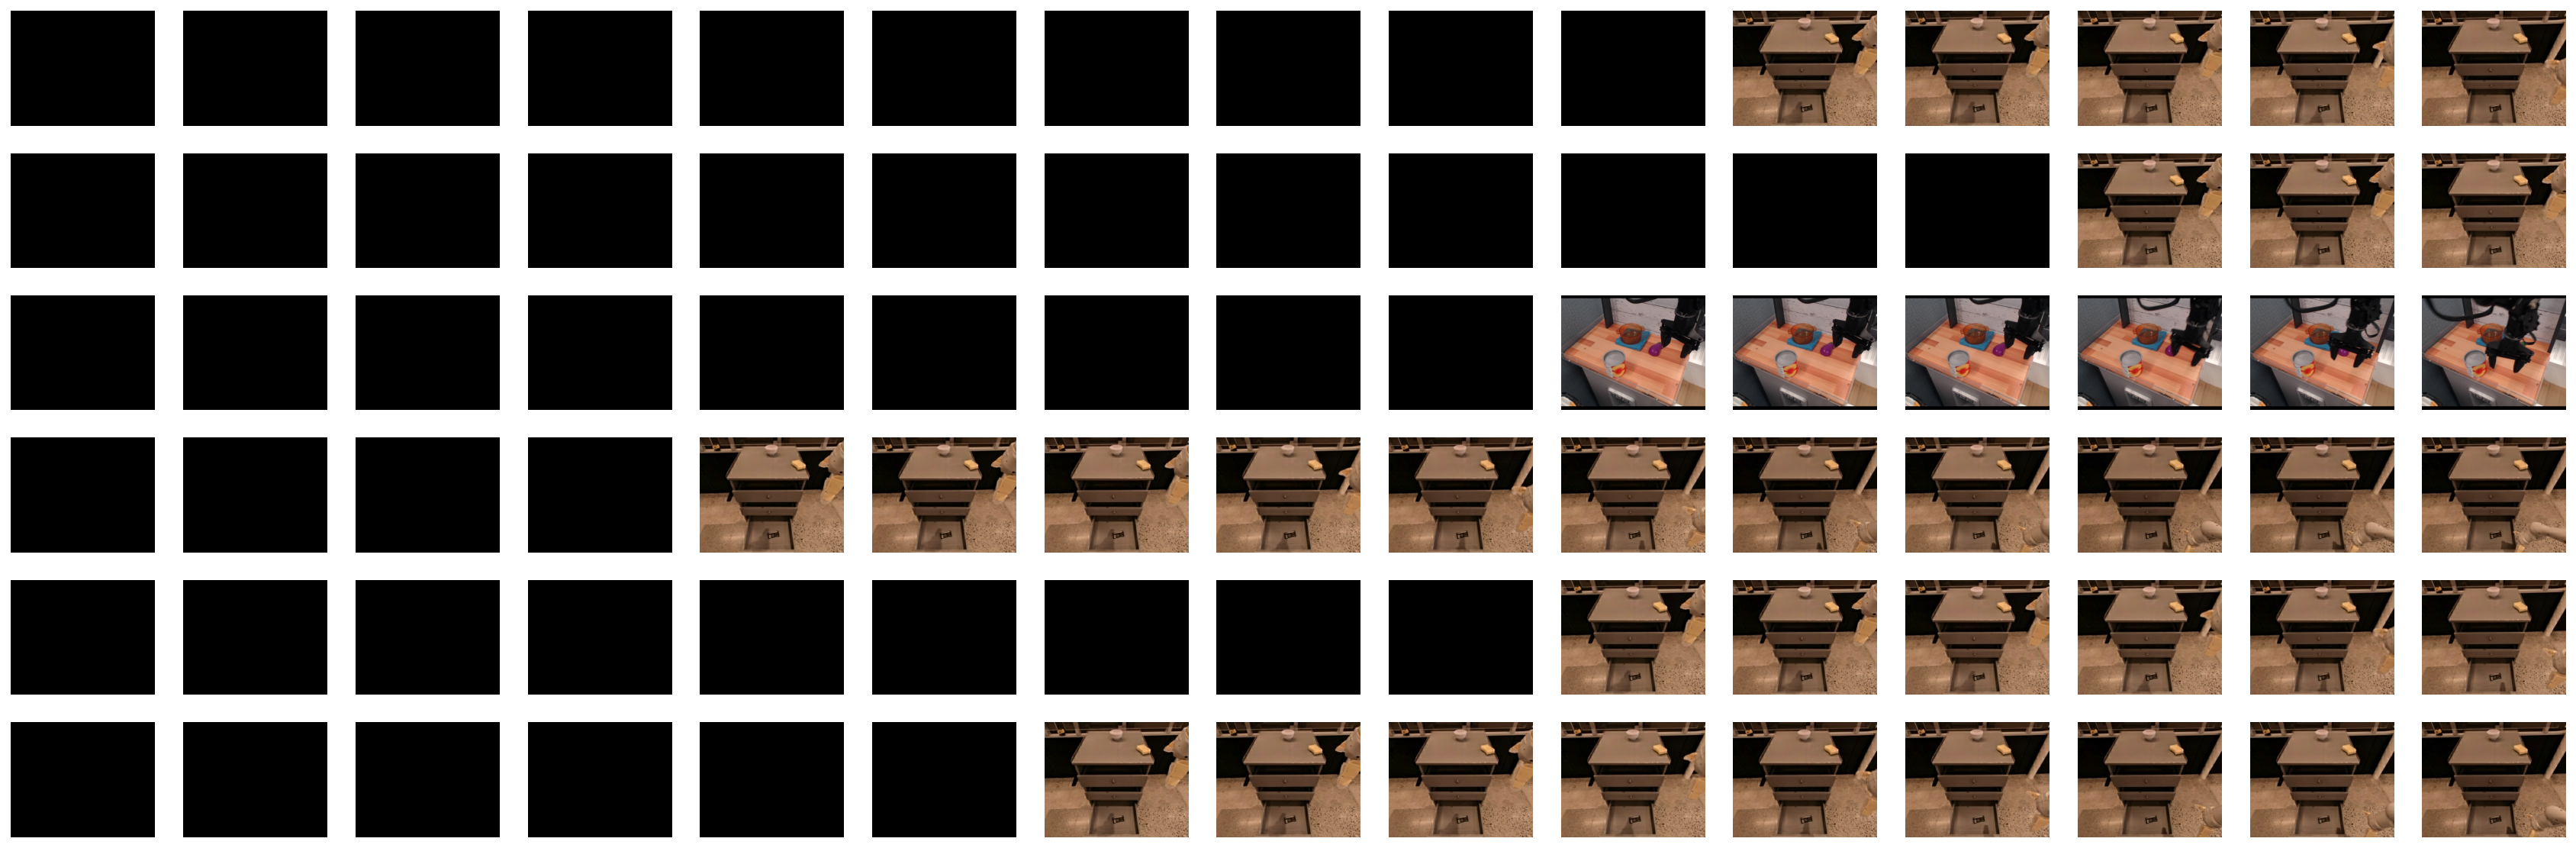

In [ ]:
# @title Visualize one batch of training data

batch_size = sample[rlds.OBSERVATION]['image'].shape[0]
trajectory_length = sample[rlds.OBSERVATION]['image'].shape[1]

fig, axs = plt.subplots(nrows=batch_size,
                        ncols=trajectory_length,
                        figsize=(30, 10))

for batch_index in range(batch_size):
  for trajectory_index in range(trajectory_length):
    axs[batch_index, trajectory_index].imshow(
        sample[rlds.OBSERVATION]['image'][batch_index, trajectory_index])
    axs[batch_index, trajectory_index].axis('off')

plt.show()